In [1]:
%%capture
from datasets import load_dataset

# Predefine parameters
dataset = load_dataset("scaredmeow/hatespeech-for-demo")
pretrained = "scaredmeow/xlnet-tagalog-base"


In [2]:
%%capture
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
)
import evaluate
from collections import Counter
from random import randint
import numpy as np


# Tokenizer and Model Loading
tokenizer = AutoTokenizer.from_pretrained(pretrained)
model = AutoModelForSequenceClassification.from_pretrained(pretrained, num_labels=2)


def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt",
    )


# Tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Model Hyperparameters, and Training Arguements
training_args = TrainingArguments(
    output_dir=f"trainer",
    learning_rate=2e-5,
    # weight_decay=1e-8,
    # adam_epsilon=1e-6,
    # adam_beta1=0.9,
    # adam_beta2=0.999,
    # warmup_ratio=0.1,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    evaluation_strategy="epoch",
    logging_steps=500,
    logging_dir="logs",
    overwrite_output_dir=True,
    save_strategy="epoch",
    seed=42,
)


In [3]:
%%capture
# Enhanced Adaptation II - Finetuning (Smaller Dataset) -> Bagging Ensemble
class EnsembleTransformers:
    def __init__(self, model, model_type, training_args, count: int, dataset, data_pct):
        self.model = model.to("cuda")
        self.model_type = model_type
        self.training_args = training_args
        self.count = count
        self.dataset = dataset
        self.data_pct = data_pct
        self.predictions = []
        self.validation_dataset = self.dataset["validation"].shuffle(seed=42)
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained)

    def dataset_bootstrapping(self, seed):
        return (
            self.dataset["train"]
            .shuffle(seed=seed)
            .select(range(int((len(self.dataset["train"]) * self.data_pct))))
        )

    def dataset_bootstrapping_eval(self, seed):
        return (
            self.dataset["test"]
            .shuffle(seed=seed)
            .select(range(int((len(self.dataset["test"]) * self.data_pct))))
        )

    def aggregate(self):
        metric = evaluate.load("accuracy")

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            return metric.compute(predictions=predictions, references=labels)


        idx = 0
        for i in range(self.count):
            rand_seed = randint(0, 100)
            train = self.dataset_bootstrapping(rand_seed)
            eval = self.dataset_bootstrapping_eval(rand_seed)
            trainer = Trainer(
                    model=self.model.to("cuda"),
                    args=self.training_args,
                    train_dataset=train,
                    eval_dataset=eval,
                    compute_metrics=compute_metrics,

            )
            idx += 1
            print(idx)
            self.training_args.output_dir = f"{self.model_type}-trainer-{i}"
            trainer.train()
            trainer.save_model(f"{self.model_type}-{idx}")
            self.tokenizer.save_pretrained(f"{self.model_type}-{idx}")
            self.predictions.append(np.argmax(
                    trainer.predict(self.validation_dataset).predictions, axis=1
                ).tolist())
        majority_vote = []
        for i in range(len(self.predictions[0])):
            majority_vote.append(
                Counter(
                    [self.predictions[j][i] for j in range(len(self.predictions))]
                ).most_common(1)[0][0]
            )
        print(self.predictions)
        return majority_vote



In [4]:
# return np.argmax(
#         trainer.predict(self.validation_dataset).predictions, axis=1
#     ).tolist()

# def train(self):
#     idx = 0
#     for trainer in self.train_setup():
#         idx += 1
#         trainer.train()
#         trainer.save_model(f"{self.model_type}-{idx}")
#         self.tokenizer.save_pretrained(f"{self.model_type}-{idx}")

#     return self.trainer

# def predict(self):
#     for trainer in self.train():
#         self.predictions.append(
#             np.argmax(
#                 trainer.predict(self.validation_dataset).predictions, axis=1
#             ).tolist()
#         )
#     # Aggregation
#     true_pred = []
#     for i in range(len(self.predictions[0])):
#         true_pred.append(
#             Counter(
#                 [self.predictions[j][i] for j in len(self.predictions)]
#             ).most_common(1)[0][0]
#         )
#     print(self.predictions)
#     return true_pred


In [5]:
xlnet_ensemble = EnsembleTransformers(
    model, "xlnet", training_args, 5, tokenized_datasets, 0.7
)


Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-8795e553d4ef54ed.arrow


In [6]:
pred = xlnet_ensemble.aggregate()
true = xlnet_ensemble.validation_dataset["label"]


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


1


wandb: Currently logged in as: scaredmeow. Use `wandb login --relogin` to force relogin


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 0.6744, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.6031, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.557, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 0.5343638062477112, 'eval_accuracy': 0.7288993923024983, 'eval_runtime': 415.4717, 'eval_samples_per_second': 7.129, 'eval_steps_per_second': 1.784, 'epoch': 1.0}
{'loss': 0.5452, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.5411, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.5731, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.5916, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 0.766548752784729, 'eval_accuracy': 0.7650236326806212, 'eval_runtime': 413.7642, 'eval_samples_per_second': 7.159, 'eval_steps_per_second': 1.791, 'epoch': 2.0}
{'loss': 0.446, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.4853, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.4383, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.0119816064834595, 'eval_accuracy': 0.7741390952059419, 'eval_runtime': 415.379, 'eval_samples_per_second': 7.131, 'eval_steps_per_second': 1.784, 'epoch': 3.0}
{'train_runtime': 7850.9273, 'train_samples_per_second': 2.675, 'train_steps_per_second': 0.669, 'train_loss': 0.5410676690964472, 'epoch': 3.0}


  0%|          | 0/1058 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-371d9cd4b09d224f.arrow


2


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 0.5876, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.6227, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.5934, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 0.8633129000663757, 'eval_accuracy': 0.7738014854827819, 'eval_runtime': 419.6683, 'eval_samples_per_second': 7.058, 'eval_steps_per_second': 1.766, 'epoch': 1.0}
{'loss': 0.5576, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.4558, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.437, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.4142, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.139007806777954, 'eval_accuracy': 0.7805536799459825, 'eval_runtime': 426.9822, 'eval_samples_per_second': 6.937, 'eval_steps_per_second': 1.735, 'epoch': 2.0}
{'loss': 0.2716, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.3158, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.2802, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.204692006111145, 'eval_accuracy': 0.775489534098582, 'eval_runtime': 405.5583, 'eval_samples_per_second': 7.304, 'eval_steps_per_second': 1.827, 'epoch': 3.0}
{'train_runtime': 8003.2322, 'train_samples_per_second': 2.624, 'train_steps_per_second': 0.656, 'train_loss': 0.44959686133975074, 'epoch': 3.0}


  0%|          | 0/1058 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-371d9cd4b09d224f.arrow
Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-11fe736dd61728e6.arrow


3


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 0.2308, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.2556, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.2635, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.1799168586730957, 'eval_accuracy': 0.7683997299122215, 'eval_runtime': 432.3588, 'eval_samples_per_second': 6.851, 'eval_steps_per_second': 1.714, 'epoch': 1.0}
{'loss': 0.2868, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.1968, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.1546, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.1482, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.549100399017334, 'eval_accuracy': 0.7846049966239028, 'eval_runtime': 415.8414, 'eval_samples_per_second': 7.123, 'eval_steps_per_second': 1.782, 'epoch': 2.0}
{'loss': 0.0848, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.1056, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.1435, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.5261931419372559, 'eval_accuracy': 0.7819041188386225, 'eval_runtime': 421.6137, 'eval_samples_per_second': 7.025, 'eval_steps_per_second': 1.758, 'epoch': 3.0}
{'train_runtime': 7955.174, 'train_samples_per_second': 2.64, 'train_steps_per_second': 0.66, 'train_loss': 0.183605830964588, 'epoch': 3.0}


  0%|          | 0/1058 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-371d9cd4b09d224f.arrow
Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-11fe736dd61728e6.arrow


4


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 0.109, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.0999, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.1206, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.339573621749878, 'eval_accuracy': 0.7744767049291019, 'eval_runtime': 415.3973, 'eval_samples_per_second': 7.131, 'eval_steps_per_second': 1.784, 'epoch': 1.0}
{'loss': 0.1472, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.1302, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.0631, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.0528, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.7732123136520386, 'eval_accuracy': 0.7846049966239028, 'eval_runtime': 416.8652, 'eval_samples_per_second': 7.105, 'eval_steps_per_second': 1.778, 'epoch': 2.0}
{'loss': 0.0347, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.064, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.0782, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.6206291913986206, 'eval_accuracy': 0.7835921674544227, 'eval_runtime': 420.3001, 'eval_samples_per_second': 7.047, 'eval_steps_per_second': 1.763, 'epoch': 3.0}
{'train_runtime': 7961.1241, 'train_samples_per_second': 2.638, 'train_steps_per_second': 0.659, 'train_loss': 0.0929542697724842, 'epoch': 3.0}


  0%|          | 0/1058 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-371d9cd4b09d224f.arrow
Loading cached shuffled indices for dataset at C:\Users\Neilc\.cache\huggingface\datasets\scaredmeow___csv\scaredmeow--hatespeech-for-demo-f0aace51d8399ff3\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-11fe736dd61728e6.arrow


5


c:\Users\Neilc\dev\proj\nlp-thesis-xlnet-tagalog\.venv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5250 [00:00<?, ?it/s]

{'loss': 0.0852, 'learning_rate': 1.8095238095238097e-05, 'epoch': 0.29}
{'loss': 0.0477, 'learning_rate': 1.6190476190476193e-05, 'epoch': 0.57}
{'loss': 0.0845, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.7643860578536987, 'eval_accuracy': 0.7738014854827819, 'eval_runtime': 407.4208, 'eval_samples_per_second': 7.27, 'eval_steps_per_second': 1.819, 'epoch': 1.0}
{'loss': 0.0922, 'learning_rate': 1.2380952380952383e-05, 'epoch': 1.14}
{'loss': 0.0731, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.0672, 'learning_rate': 8.571428571428571e-06, 'epoch': 1.71}
{'loss': 0.0439, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.9432156085968018, 'eval_accuracy': 0.7744767049291019, 'eval_runtime': 453.431, 'eval_samples_per_second': 6.532, 'eval_steps_per_second': 1.634, 'epoch': 2.0}
{'loss': 0.0574, 'learning_rate': 4.761904761904762e-06, 'epoch': 2.29}
{'loss': 0.0537, 'learning_rate': 2.8571428571428573e-06, 'epoch': 2.57}
{'loss': 0.0996, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/741 [00:00<?, ?it/s]

{'eval_loss': 1.6225533485412598, 'eval_accuracy': 0.7802160702228225, 'eval_runtime': 401.4692, 'eval_samples_per_second': 7.378, 'eval_steps_per_second': 1.846, 'epoch': 3.0}
{'train_runtime': 7864.6398, 'train_samples_per_second': 2.67, 'train_steps_per_second': 0.668, 'train_loss': 0.07297203209286644, 'epoch': 3.0}


  0%|          | 0/1058 [00:00<?, ?it/s]

[[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,

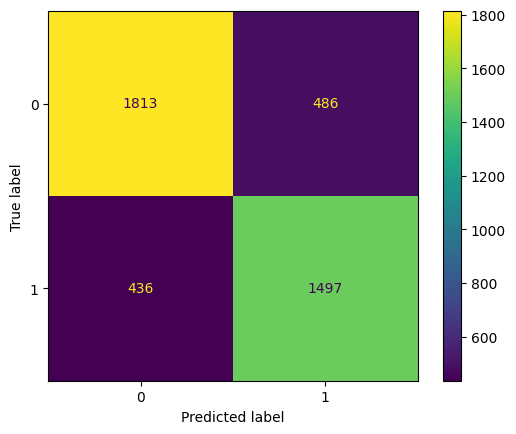

Accuracy: 0.7821361058601134
Precision: 0.780526426604798
Recall: 0.781523805194773
F1 score: 0.7809145979375145


In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# Compute the confusion matrix
cm = confusion_matrix(true, pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

# Compute the accuracy
acc = accuracy_score(true, pred)
print("Accuracy:", acc)

# Compute the precision
prec = precision_score(true, pred, average="macro")
print("Precision:", prec)

# Compute the recall
rec = recall_score(true, pred, average="macro")
print("Recall:", rec)

# Compute the f1 score
f1 = f1_score(true, pred, average="macro")
print("F1 score:", f1)

# # Compute the log-loss
# ll = log_loss(true, pred, labels=[0, 1, 2, 3, 4])
# print("Log-loss:", ll)

# # Compute the AUC-ROC
# auc = roc_auc_score(true, pred, average="macro", multi_class="ovr")
# print("AUC-ROC:", auc)
